In [1]:
# %matplotlib inline
from qutip import ket, create, destroy, identity, tensor, krylovsolve, sigmax, projection, propagator, state_number_index, state_index_number, Qobj, basis
import numpy as np
from scipy.linalg import expm
from scipy.sparse import coo_matrix
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import networkx as nx
import time
from IPython.display import HTML

In [2]:
sols = []
colors = {}
def sudoku_direct(N, grid, constraints, depth, parent, G):
    print(grid)
    print(parent)
    # print(constraints)
    if not any(0 in s for s in grid):
        return
    
    for i in range(N):
        for j in range(N):
            if grid[i,j] != 0:
                continue
            for k in range(1, N+1):
                if constraints[k-1,0,i] or constraints[k-1,1,j] or constraints[k-1,2,(i//2)*2 + (j//2)]:
                    continue
                grid2 = grid.copy()
                grid2[i,j] = k
                index = len(sols)
                for l in range(len(sols)):
                    if np.array_equal(grid2, sols[l]):
                        index = l

                G.add_edge(parent, index)
                
                if index != len(sols):
                    continue

                const = constraints.copy()
                const[k-1,0,i] = True
                const[k-1,1,j] = True
                const[k-1,2,(i//2)*2 + (j//2)] = True
                sols.append(grid2)
                colors[index] = np.count_nonzero(grid2)
                sudoku_direct(N, grid2, const, depth+1, index, G)

In [3]:
grid = np.array([[2, 4, 0, 3], [3, 0, 4, 2], [4, 0, 3, 1], [0, 0, 0, 0]])
# grid = np.array([[2, 4, 0, 3], [3, 1, 4, 2], [4, 2, 3, 1], [0, 0, 0, 0]])
constraints = np.array([[[False] * 4] * 3] * 4)

for k in range(4):
    for i in range(4):
        if (k+1) in grid[i]:
            constraints[k, 0, i] = True
        for j in range(4):
            if (k+1) in grid[:, j]:
                constraints[k, 1, j] = True
            subgrid = grid[(i//2)*2:(i//2+1)*2, (j//2)*2:(j//2+1)*2]
            if any((k+1) in s for s in subgrid):
                constraints[k,2,(i//2)*2 + (j//2)] = True


sols = [grid]
colors = {0: np.count_nonzero(grid)}
G = nx.Graph()
sudoku_direct(4, grid=grid, constraints=constraints, depth=0, parent=0, G=G)
nx.write_adjlist(G, "sudoku_graph_3.adjlist")

[[2 4 0 3]
 [3 0 4 2]
 [4 0 3 1]
 [0 0 0 0]]
0
[[2 4 1 3]
 [3 0 4 2]
 [4 0 3 1]
 [0 0 0 0]]
1
[[2 4 1 3]
 [3 1 4 2]
 [4 0 3 1]
 [0 0 0 0]]
2
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 0 0 0]]
3
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 0 0 0]]
4
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 3 0 0]]
5
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 3 2 0]]
6
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 3 2 4]]
7
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 3 0 4]]
8
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 0 2 0]]
9
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 0 2 4]]
10
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [1 0 0 4]]
11
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 3 0 0]]
12
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 3 2 0]]
13
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 3 2 4]]
14
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 3 0 4]]
15
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 0 2 0]]
16
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 0 2 4]]
17
[[2 4 1 3]
 [3 1 4 2]
 [4 2 3 1]
 [0 0 0 4]]
18
[[2 4 1 3]
 [3 1 4 2]
 [4 0 3 1]
 [1 0 0 0]]
19
[[2 4 1 3]
 [3 1 4 2]
 [4 0 3 1]
 [1 2 0 0]]
20
[[

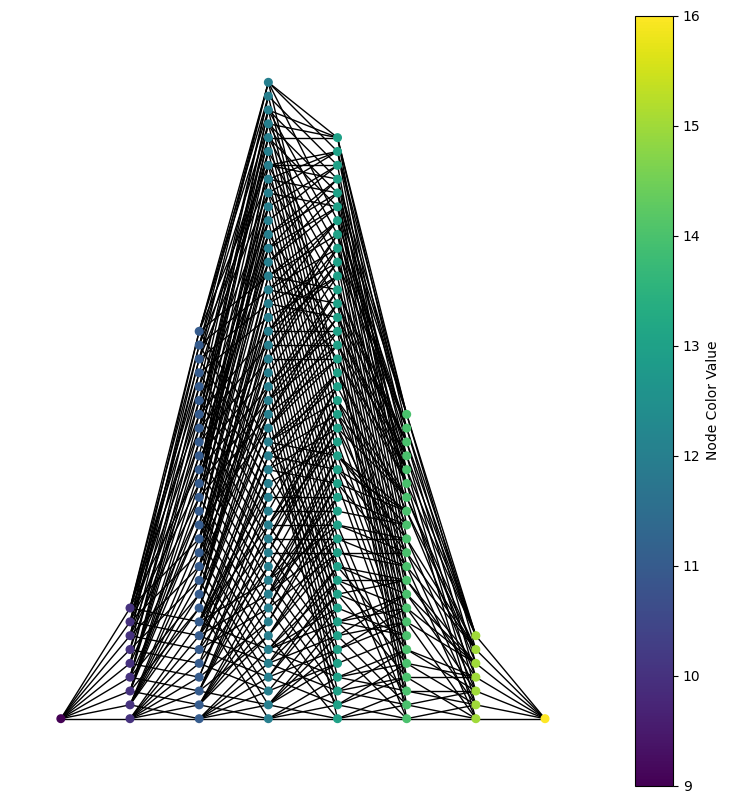

In [4]:
H = nx.adjacency_matrix(G)
# dim = 7297
dim = len(sols)
# print(H)
H = Qobj(H.todense(), [[dim], [dim]])
H = H + H.dag()

H_mat = np.abs(H.full())
G = nx.from_numpy_array(H_mat)

# Define the x-coordinate for each column based on the unique numerical values
unique_values = sorted(set(colors.values()))
column_positions = {value: i for i, value in enumerate(unique_values)}

# Create a dictionary to keep track of the number of nodes in each column
column_counts = {value: 0 for value in unique_values}

# Define a spacing factor for the y-coordinates
spacing = 1

# Create a dictionary for node positions
pos = {}
for node, value in colors.items():
    x = column_positions[value]
    y = column_counts[value] * spacing
    pos[node] = (x, y)
    column_counts[value] += 1  # Increment the count for this column

# Adjust the y_scale based on the maximum column height
max_column_height = max(column_counts.values())
y_scale = max(1, max_column_height - 1)

# Update the y-coordinates with the adjusted y_scale
for node, (x, y) in pos.items():
    pos[node] = (x*150, y*30)

node_color = [colors[node] for node in G.nodes()]
# Normalize the color values to the range [0, 1]
norm = plt.Normalize(min(node_color), max(node_color))

# Choose a colormap
cmap = cm.viridis

# Map the normalized color values to actual colors
colors = [cmap(norm(value)) for value in node_color]

G.remove_nodes_from(list(nx.isolates(G)))
# labels = {i: f"{str(labels[i][:12])}\n{str(labels[i][12:])}" for i in G.nodes()}
# nx.draw(G, with_labels=True, labels=labels, font_size=6)

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

nx.draw(G, pos=pos, node_color=colors, node_size=30, ax=ax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('# Sudoku Cells Filled')

# plt.axis('off')
plt.show()

In [10]:
# H = nx.adjacency_matrix(G)
# # dim = 7297
# dim = len(sols)
# # print(H)
# H = Qobj(H.todense(), [[dim], [dim]])
# H = H + H.dag()

# H_mat = np.abs(H.full())
# G = nx.from_numpy_array(H_mat)

# # Define the x-coordinate for each column based on the unique numerical values
# unique_values = sorted(set(colors.values()))
# column_positions = {value: i for i, value in enumerate(unique_values)}

# # Create a dictionary to keep track of the number of nodes in each column
# column_counts = {value: 0 for value in unique_values}

# # Define a spacing factor for the y-coordinates
# spacing = 1

# # Create a dictionary for node positions
# pos = {}
# for node, value in colors.items():
#     x = column_positions[value]
#     y = column_counts[value] * spacing
#     pos[node] = (x, y)
#     column_counts[value] += 1  # Increment the count for this column

# # Adjust the y_scale based on the maximum column height
# max_column_height = max(column_counts.values())
# y_scale = max(1, max_column_height - 1)

# # Update the y-coordinates with the adjusted y_scale
# for node, (x, y) in pos.items():
#     pos[node] = (x*150, y*30)

# step = 0.01
# t = np.arange(0, 10, step)
# results = krylovsolve(H, basis(dim, 0), t, krylov_dim=20, sparse=True)

# # Normalize the color values to the range [0, 1]
# norm = plt.Normalize(0, 1)

# # Choose a colormap
# cmap = cm.viridis

# color_set = []
# for psi in results.states:
#     color_set.append(np.abs(psi.full().flatten())**2)


# # Map the normalized color values to actual colors
# # print(color_set)
# # color_sequence = [[cmap(norm(value)) for value in node_color] for node_color in color_set]
# color_sequence = np.array(color_set)
# print(color_sequence.shape)

# G.remove_nodes_from(list(nx.isolates(G)))
# # labels = {i: f"{str(labels[i][:12])}\n{str(labels[i][12:])}" for i in G.nodes()}
# # nx.draw(G, with_labels=True, labels=labels, font_size=6)

# # fig, ax = plt.subplots()
# nodes = nx.draw_networkx_nodes(G, pos, node_color=color_sequence[0], node_size=30)
# nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos)

# # nx.draw(G, pos=pos, node_color=colors, node_size=30, ax=ax)

# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# # sm.set_array([])
# # cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
# # cbar.set_label('Node Color Value')

# # Update function for the animation
# def update_colors(frame):
#     nodes.set_array(color_sequence[frame])
#     return nodes,

# # Create the animation
# ani = FuncAnimation(plt.gcf(), update_colors, frames=len(color_sequence), interval=1000, blit=True)

# # Show the animation
# HTML(ani.to_html5_video())